<a href="https://colab.research.google.com/github/David-Jacobis/ItemBasedIAModel/blob/main/Python_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sua empresa foi contrada pela Netflix para construir o novo sistema de recomendação da plataforma de streaming mais famosa do mundo.
A área de negócio responsável na Netflix fez algumas observações na reunião de Kick-Off que deverão ser consideradas durante o processo:
-  **A recomendação deve ocorrer de duas formas. A primeira deve ser uma recomendação baseada no histórico do usuário, a segunda deve ser uma recomendação baseada no perfil pessoal do usuário.
Algumas exigências foram feitas pelo Netflix.**
- O Desenvolvimento completo do projeto deve ser feito em Python, versão 3.8 ou superiro e todo o ambiente de desenvolvimento deve ser reproduzido a qualquer momento.
- O dataset será fornecido pela equipe de dados do Netflix.
- Sua equipe deverá fornecer insigths relevantes sobre a base de dados, estes insights também serão utilizados pela Netflix para melhorar seu processo de Engenharia de Dados. Para seu time, os insights serão os guias no desenho dos modelos de recomendação.
- Deverão ser criados pelo menos 2 modelos com abordagens diferentes para serem utilizados pela Netflix.
- Todas as decisões de modelagem, definição de hyper parametros e etc devem ser documentadas e justificadas do porque da utilização.
- Deverá ser apresentado relatório completo do desempenho dos modelos treinados, considerando métricas relevantes para a análise destes desempenhos.
- A equipe deverá criar um pipeline teórico de deploy completo projeto em alguma plataforma de núvem (podendo ser Google Cloud Platform, AWS e Microsoft Azure)
- O Projeto deverá ser publicado em repositório GIT.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime as date
import numpy as np
!pip install Faker
from faker import Faker
from sklearn.metrics.pairwise import cosine_similarity
!pip install scikit-surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

In [ ]:
dbMovies = pd.read_csv("/content/drive/MyDrive/Atividade Python - A3/movies.csv")
dbRates = pd.read_csv("/content/drive/MyDrive/Atividade Python - A3/ratings.csv")

In [ ]:
dbMovies.head()

In [ ]:
dbRates.head()

userId  movieId  rating   timestamp
0       1       16     4.0  1217897793
1       1       24     1.5  1217895807
2       1       32     4.0  1217896246
3       1       47     4.0  1217896556
4       1       50     4.0  1217896523

In [ ]:
dbDataset = pd.merge(dbMovies, dbRates, on="movieId", how="inner")

In [ ]:
#colocar seed
np.random.seed(1)
df = pd.DataFrame(dbDataset)
#Criação de dados fictícios para que seja feita uma melhor análise de um perfil de usuário
idade_base  = np.random.randint(8, 91, size=len(df))
fator_variacao = 0.71
df['age'] = np.clip((idade_base * fator_variacao).astype(int), 8, 91)

media_salario = 1200
desvio_padrao_salario = 2.7
df['salary'] = np.random.lognormal(mean=np.log(media_salario), sigma=desvio_padrao_salario, size=len(df))
df['salary'] = np.clip(df['salary'], 1200, 120000)
df['salary'] = df['salary'].round(2)
fake = Faker()
nomes_ficticios = [fake.name() for _ in range(100000)]
df['full_name'] = np.random.choice(nomes_ficticios, size=len(df))
estados_reais = [
    'Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal',
    'Espírito Santo', 'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul',
    'Minas Gerais', 'Pará', 'Paraíba', 'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro',
    'Rio Grande do Norte', 'Rio Grande do Sul', 'Rondônia', 'Roraima', 'Santa Catarina',
    'São Paulo', 'Sergipe', 'Tocantins'
]
df['states'] = np.random.choice(estados_reais, size=len(df))
dbDataset.head()

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  age   salary           full_name  \
0       2     5.0   859046895   31  7431.47        Allison Ward   
1       5     4.0  1303501039   14  1200.00  Christopher Holden   
2       8     5.0   858610933   56  2346.89         Keith Young   
3      11     4.0   850815810   12  1200.00        Joshua Smith   
4      14     4.0   851766286   58  3556.93          Taylor Lee   

           states  
0  Rio de Janeiro  
1           Goiás  
2    Minas Gerais  
3      Pernambuco  
4         Roraima

In [ ]:
dfAnalise = dbDataset.copy()

In [ ]:
dfAnalise["faixaSalario"] = pd.cut(dfAnalise["salary"],bins=6)

In [ ]:
dfAnalise.shape

(105339, 11)

In [ ]:
def separaGeneroFilme(gen):
  """
  """
  return gen.split("|")

addField = []
addId = []
for index, row in dfAnalise.iterrows():
  generos = separaGeneroFilme(row["genres"])
  for genero in generos:
    addField.append(genero)
    addId.append(row["movieId"])
dfAux = pd.DataFrame()
dfAux["genero"] = addField
dfAux["movieId"] = addId
dfAux.head()



genero  movieId
0  Adventure        1
1  Animation        1
2   Children        1
3     Comedy        1
4    Fantasy        1

In [ ]:
dfAnalise2 = pd.merge(dfAnalise, dfAux, on="movieId", how="inner")

In [ ]:
dfAnalise2.drop_duplicates()

movieId                                title  \
0               1                     Toy Story (1995)   
1               1                     Toy Story (1995)   
2               1                     Toy Story (1995)   
3               1                     Toy Story (1995)   
4               1                     Toy Story (1995)   
...           ...                                  ...   
18889763   148238       A Very Murray Christmas (2015)   
18889764   148626                 The Big Short (2015)   
18889767   148626                 The Big Short (2015)   
18889770   148626                 The Big Short (2015)   
18889773   149532  Marco Polo: One Hundred Eyes (2015)   

                                               genres  userId  rating  \
0         Adventure|Animation|Children|Comedy|Fantasy       2     5.0   
1         Adventure|Animation|Children|Comedy|Fantasy       2     5.0   
2         Adventure|Animation|Children|Comedy|Fantasy       2     5.0   
3         Adventure|Animation|Children|Comedy|Fantasy       2     5.0   
4         Adventure|Animation|Children|Comedy|Fantasy       2     5.0   
...                                               ...     ...     ...   
18889763                                       Comedy     475     3.0   
18889764                                        Drama     458     4.0   
18889767                                        Drama     576     4.5   
18889770                                        Drama     668     4.5   
18889773                           (no genres listed)     475     4.0   

           timestamp  age   salary         full_name               states  \
0          859046895   31  7431.47      Allison Ward       Rio de Janeiro   
1          859046895   31  7431.47      Allison Ward       Rio de Janeiro   
2          859046895   31  7431.47      Allison Ward       Rio de Janeiro   
3          859046895   31  7431.47      Allison Ward       Rio de Janeiro   
4          859046895   31  7431.47      Allison Ward       Rio de Janeiro   
...              ...  ...      ...               ...                  ...   
18889763  1451213043   19  1200.00  Melissa Phillips                Bahia   
18889764  1452014749   36  7885.96       Timothy Roy              Paraíba   
18889767  1451687664   12  1200.00   Michele Stewart  Rio Grande do Norte   
18889770  1451148148   46  1867.96     Amanda Rogers   Mato Grosso do Sul   
18889773  1451223429   53  4839.51      Rachel Scott              Paraíba   

               faixaSalario              genero  
0         (1081.2, 21000.0]           Adventure  
1         (1081.2, 21000.0]           Animation  
2         (1081.2, 21000.0]            Children  
3         (1081.2, 21000.0]              Comedy  
4         (1081.2, 21000.0]             Fantasy  
...                     ...                 ...  
18889763  (1081.2, 21000.0]              Comedy  
18889764  (1081.2, 21000.0]               Drama  
18889767  (1081.2, 21000.0]               Drama  
18889770  (1081.2, 21000.0]               Drama  
18889773  (1081.2, 21000.0]  (no genres listed)  

[281904 rows x 12 columns]

In [ ]:
dfAnalise = dfAnalise2[["rating","salary","genero"]].copy()

[Text(0, 0, '(no genres listed)'),
 Text(1, 0, 'Action'),
 Text(2, 0, 'Adventure'),
 Text(3, 0, 'Animation'),
 Text(4, 0, 'Children'),
 Text(5, 0, 'Comedy'),
 Text(6, 0, 'Crime'),
 Text(7, 0, 'Documentary'),
 Text(8, 0, 'Drama'),
 Text(9, 0, 'Fantasy'),
 Text(10, 0, 'Film-Noir'),
 Text(11, 0, 'Horror'),
 Text(12, 0, 'IMAX'),
 Text(13, 0, 'Musical'),
 Text(14, 0, 'Mystery'),
 Text(15, 0, 'Romance'),
 Text(16, 0, 'Sci-Fi'),
 Text(17, 0, 'Thriller'),
 Text(18, 0, 'War'),
 Text(19, 0, 'Western')]

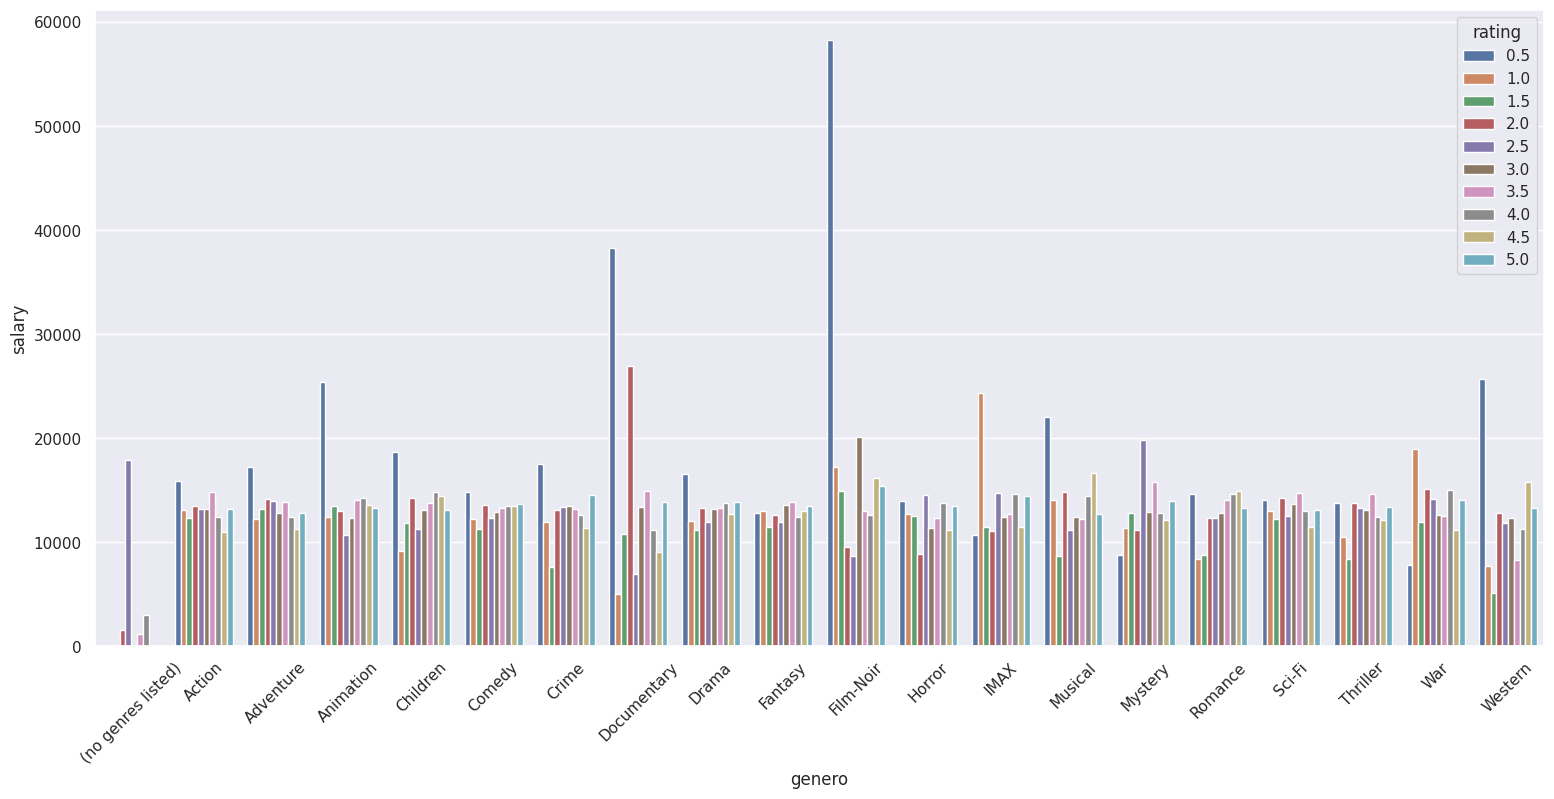

In [ ]:
dfData = dfAnalise.groupby(["genero","rating"]).mean().reset_index()
# dfData

sns.set(rc={'figure.figsize':(18.7,8.27)})
myPlot = sns.barplot(data=dfData,
            x="genero",
            y="salary",
            hue="rating")
myPlot.set_xticklabels(myPlot.get_xticklabels(), rotation=45)

[Text(0, 0, '(no genres listed)'),
 Text(1, 0, 'Action'),
 Text(2, 0, 'Adventure'),
 Text(3, 0, 'Animation'),
 Text(4, 0, 'Children'),
 Text(5, 0, 'Comedy'),
 Text(6, 0, 'Crime'),
 Text(7, 0, 'Documentary'),
 Text(8, 0, 'Drama'),
 Text(9, 0, 'Fantasy'),
 Text(10, 0, 'Film-Noir'),
 Text(11, 0, 'Horror'),
 Text(12, 0, 'IMAX'),
 Text(13, 0, 'Musical'),
 Text(14, 0, 'Mystery'),
 Text(15, 0, 'Romance'),
 Text(16, 0, 'Sci-Fi'),
 Text(17, 0, 'Thriller'),
 Text(18, 0, 'War'),
 Text(19, 0, 'Western')]

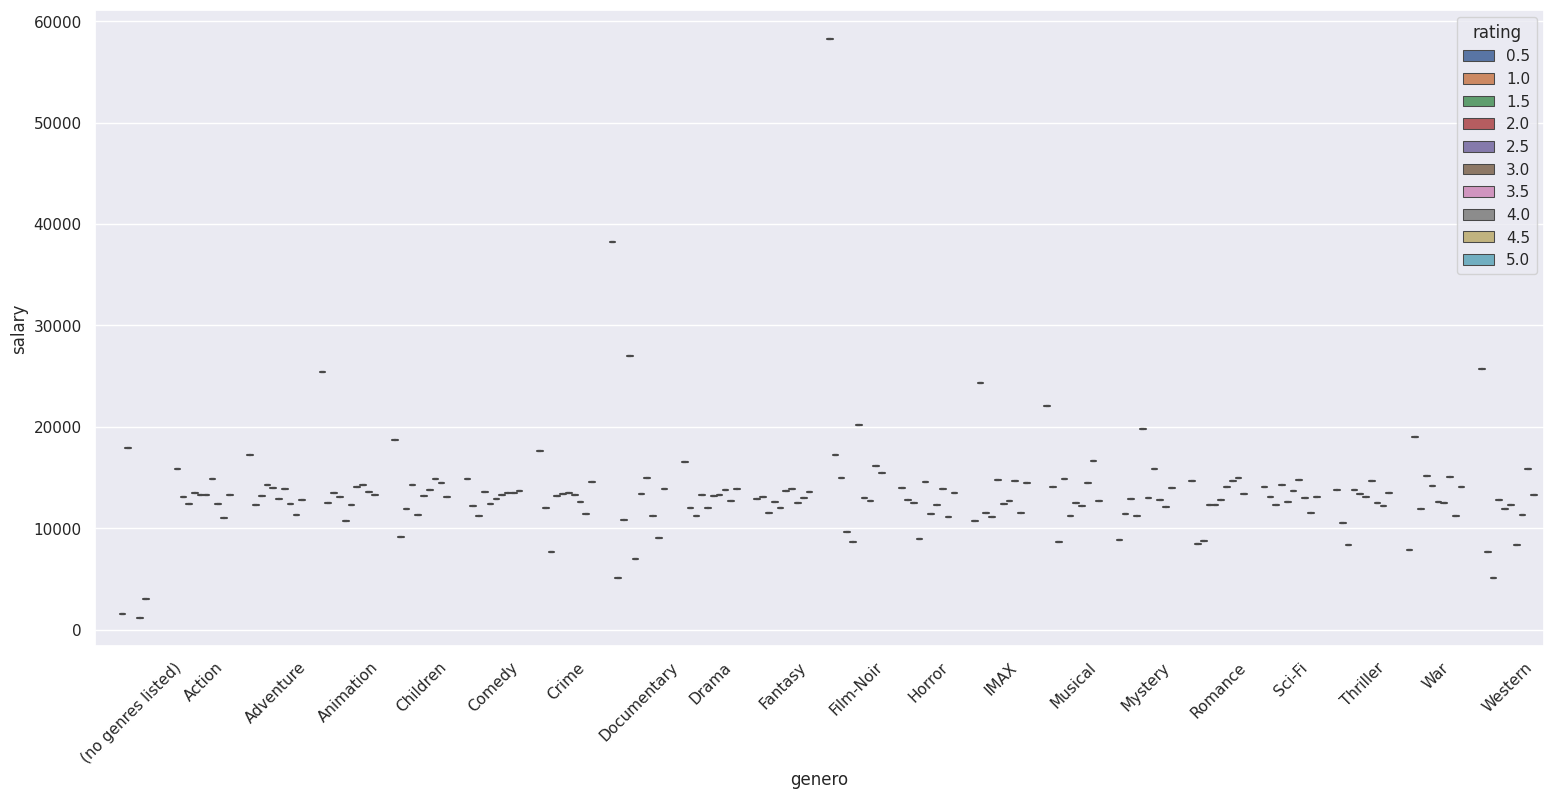

In [ ]:
dfData = dfAnalise.groupby(["genero","rating"]).mean().reset_index()
# dfData

sns.set(rc={'figure.figsize':(18.7,8.27)})
myPlot = sns.boxplot(data=dfData,
            x="genero",
            y="salary",
            hue="rating")
myPlot.set_xticklabels(myPlot.get_xticklabels(), rotation=45)

[Text(0, 0, 'Adventure'),
 Text(1, 0, 'Animation'),
 Text(2, 0, 'Children'),
 Text(3, 0, 'Comedy'),
 Text(4, 0, 'Fantasy'),
 Text(5, 0, 'Romance'),
 Text(6, 0, 'Drama'),
 Text(7, 0, 'Action'),
 Text(8, 0, 'Crime'),
 Text(9, 0, 'Thriller'),
 Text(10, 0, 'Horror'),
 Text(11, 0, 'Mystery'),
 Text(12, 0, 'Sci-Fi'),
 Text(13, 0, 'IMAX'),
 Text(14, 0, 'War'),
 Text(15, 0, 'Musical'),
 Text(16, 0, 'Documentary'),
 Text(17, 0, 'Western'),
 Text(18, 0, 'Film-Noir'),
 Text(19, 0, '(no genres listed)')]

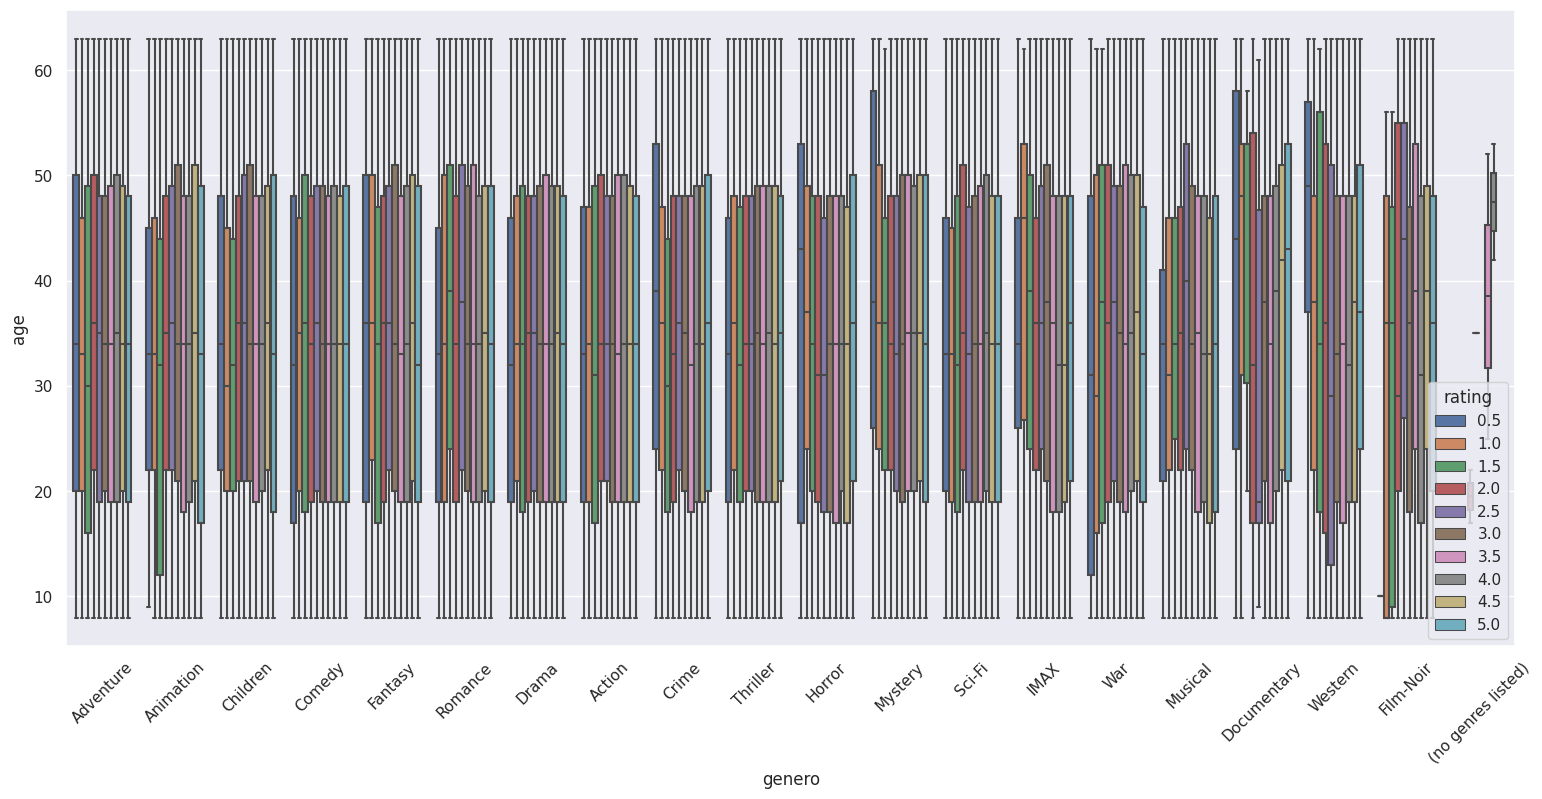

In [ ]:
dfData = dfAnalise2[["rating","age","genero"]].copy()
# dfData = dfAnalise.groupby(["genero","rating"]).mean().reset_index()
# dfData

sns.set(rc={'figure.figsize':(18.7,8.27)})
myPlot = sns.boxplot(data=dfData,
            x="genero",
            y="age",
            hue="rating")
myPlot.set_xticklabels(myPlot.get_xticklabels(), rotation=45)

Relação Gênero com Rating.
Quais gêneros tendem a melhor rating.
Rating em relação ao TimeStamp. (Feito)
Variação de Gênero em relação ao TimeStamp

In [ ]:
# Verificar se existem valores faltantes (nulos) no dataframe como um todo
dbDataset.isnull()

movieId  title  genres  userId  rating  timestamp    age  salary  \
0         False  False   False   False   False      False  False   False   
1         False  False   False   False   False      False  False   False   
2         False  False   False   False   False      False  False   False   
3         False  False   False   False   False      False  False   False   
4         False  False   False   False   False      False  False   False   
...         ...    ...     ...     ...     ...        ...    ...     ...   
105334    False  False   False   False   False      False  False   False   
105335    False  False   False   False   False      False  False   False   
105336    False  False   False   False   False      False  False   False   
105337    False  False   False   False   False      False  False   False   
105338    False  False   False   False   False      False  False   False   

        full_name  states  
0           False   False  
1           False   False  
2           False   False  
3           False   False  
4           False   False  
...           ...     ...  
105334      False   False  
105335      False   False  
105336      False   False  
105337      False   False  
105338      False   False  

[105339 rows x 10 columns]

In [ ]:
# Verificar se existem valores faltantes (nulos) por colunas
dbDataset.isnull().any()

movieId      False
title        False
genres       False
userId       False
rating       False
timestamp    False
age          False
salary       False
full_name    False
states       False
dtype: bool

<Axes: >

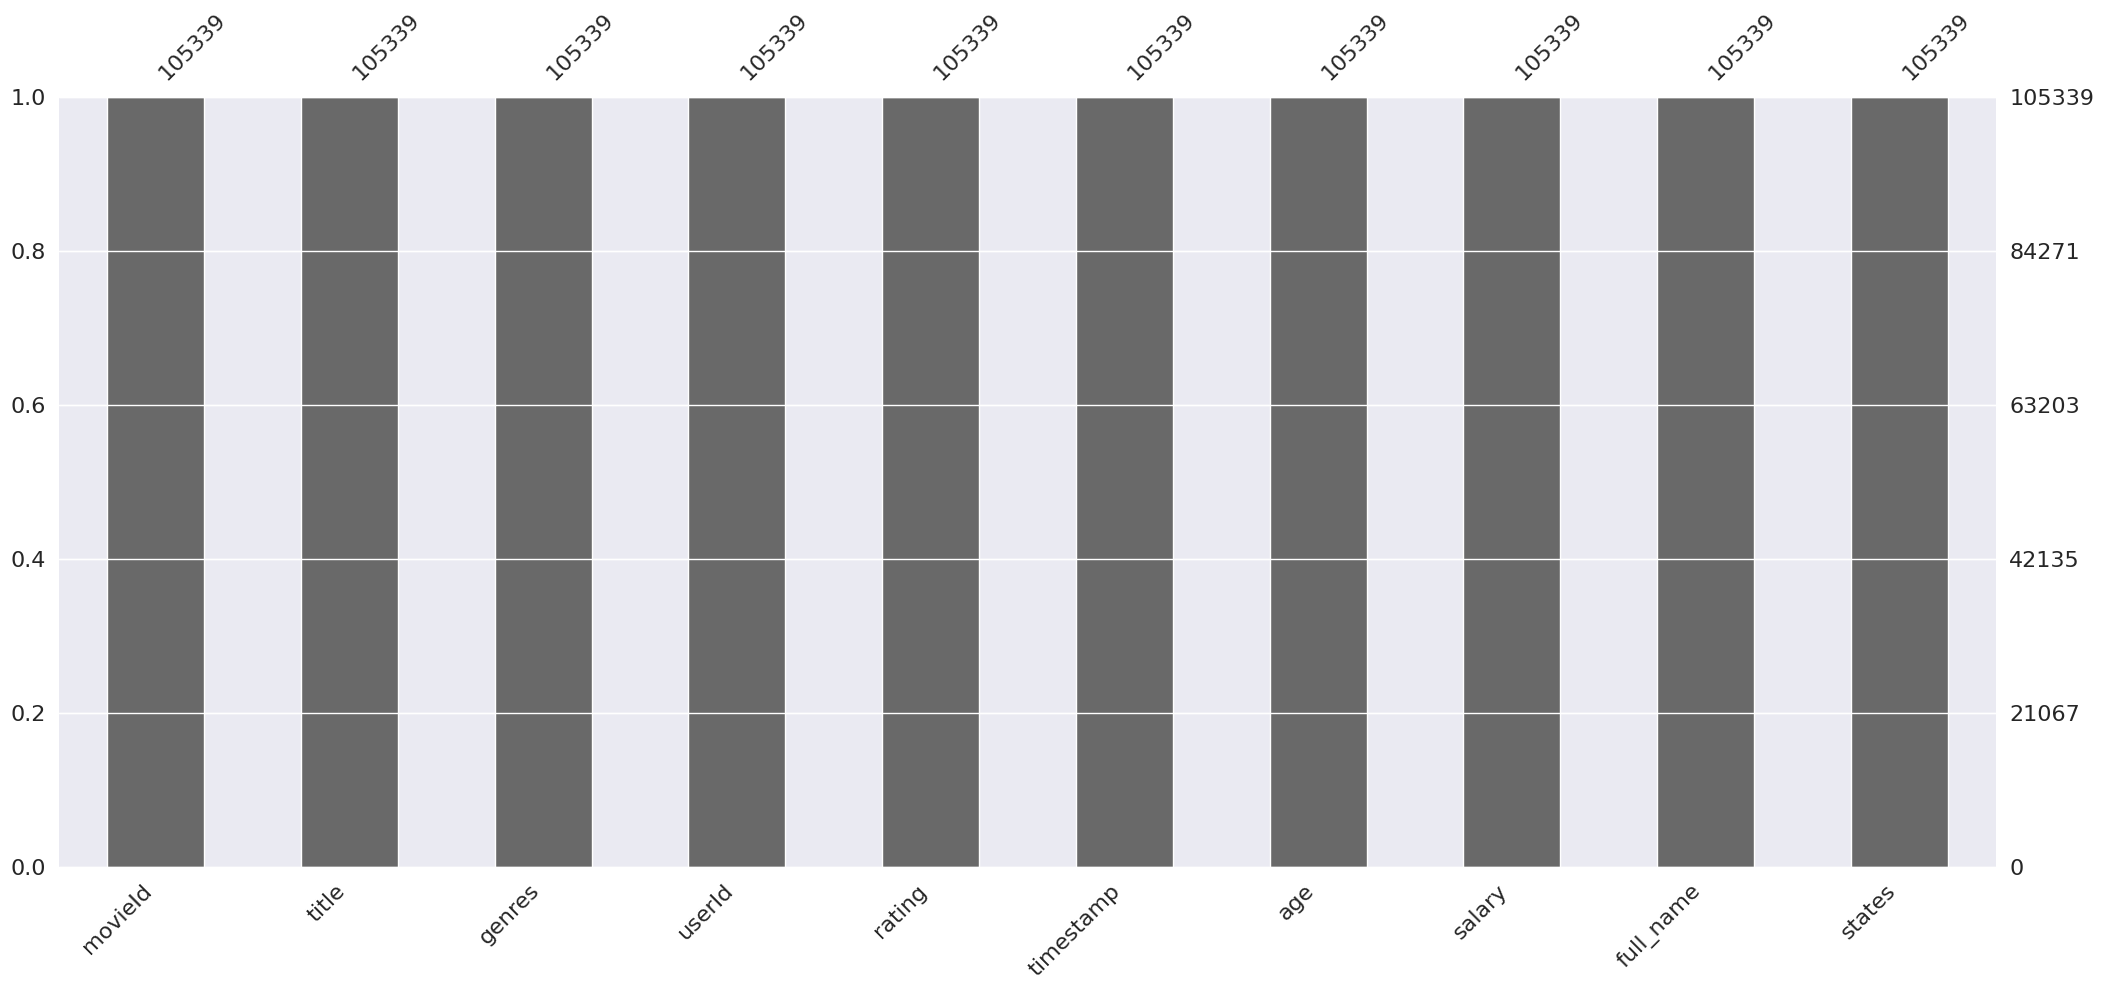

In [ ]:
msno.bar(dbDataset)

Colunas para análise: ['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp', 'Idade', 'age', 'salary', 'full_name', 'states']

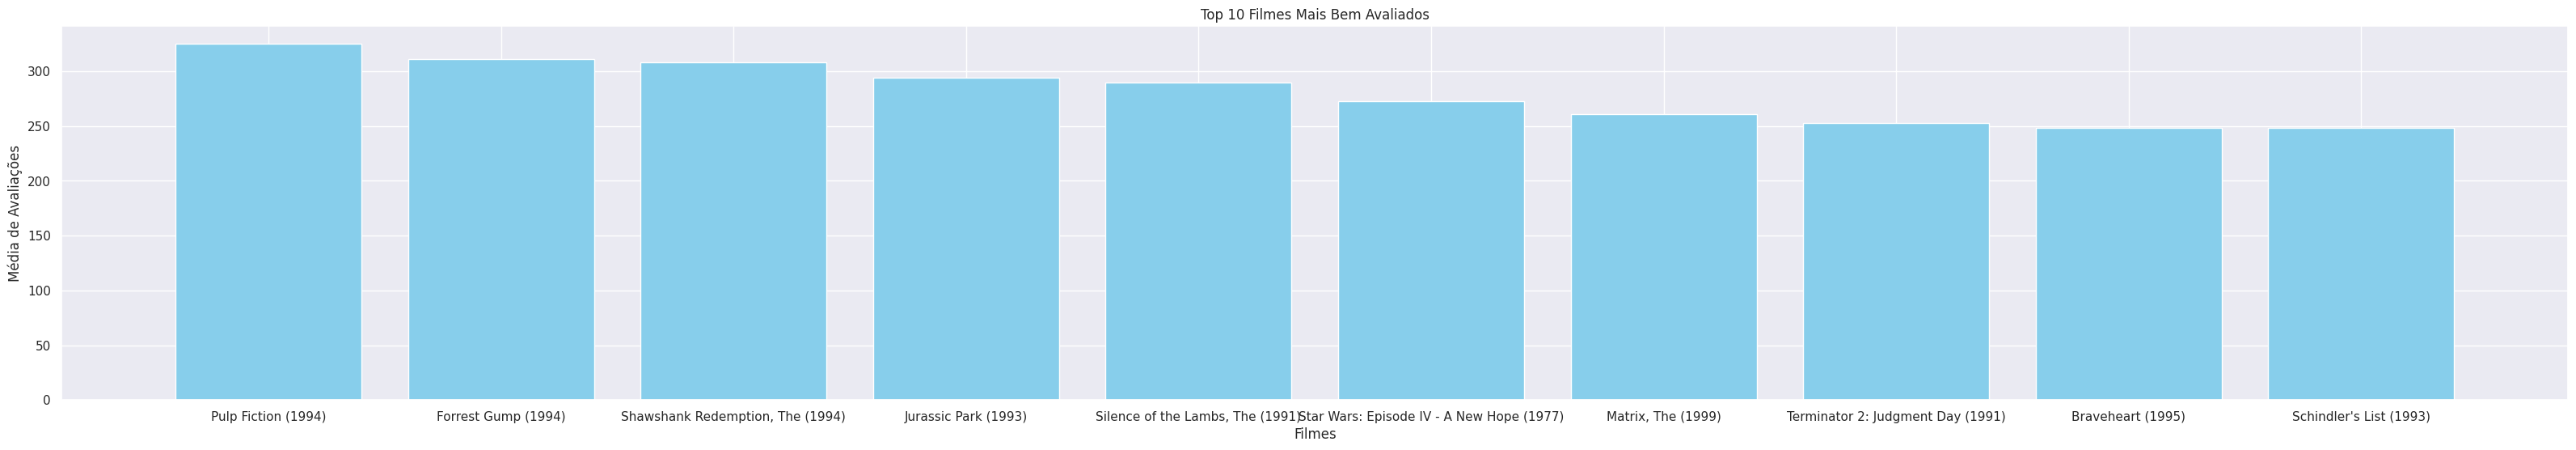

In [ ]:
dfFilmes = pd.DataFrame(dbDataset)

# Calcular a média de avaliações por título
media_avaliacoes = dfFilmes.groupby('title')['rating'].count().reset_index()

# Ordenar em ordem decrescente e pegar os top 10
top_10_filmes_mais_bem_avaliados = media_avaliacoes.sort_values(by='rating', ascending=False).head(10)

# Criar um gráfico de barras para o top 10 filmes mais bem avaliados
plt.figure(figsize=(40, 6))
plt.bar(top_10_filmes_mais_bem_avaliados['title'], top_10_filmes_mais_bem_avaliados['rating'], color='skyblue')

# Adicionar rótulos e título
plt.xlabel('Filmes')
plt.ylabel('Média de Avaliações')
plt.title('Top 10 Filmes Mais Bem Avaliados')

plt.show()

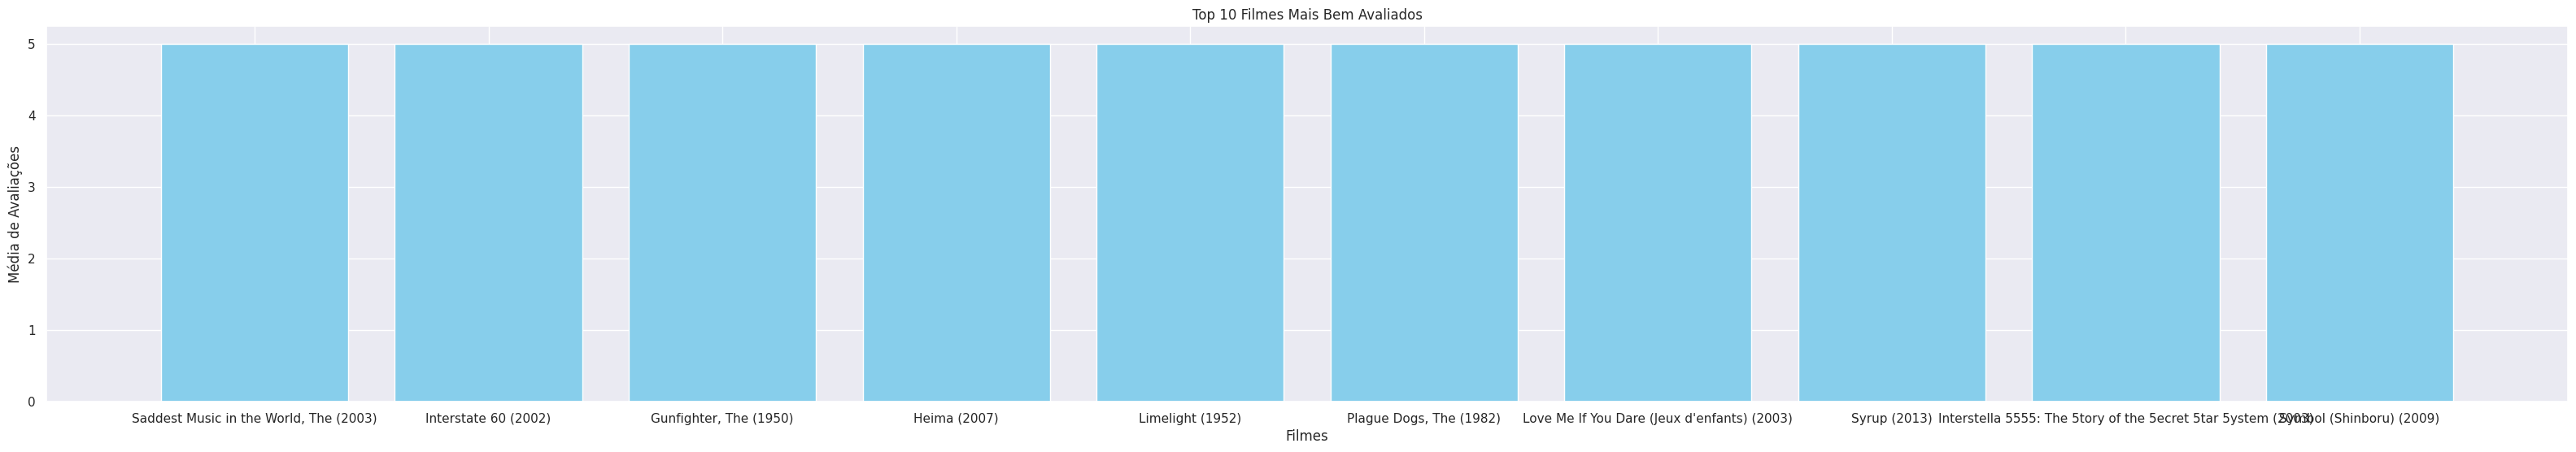

In [ ]:
dfFilmes = pd.DataFrame(dbDataset)

# Calcular a média de avaliações por filme
media_avaliacoes = dfFilmes.groupby('title')['rating'].mean().reset_index()

# Ordenar em ordem decrescente e pegar os top 10
top_10_filmes_mais_bem_avaliados = media_avaliacoes.sort_values(by='rating', ascending=False).head(10)

# Criar um gráfico de barras para o top 10 filmes mais bem avaliados
plt.figure(figsize=(40, 6))
plt.bar(top_10_filmes_mais_bem_avaliados['title'], top_10_filmes_mais_bem_avaliados['rating'], color='skyblue')

# Adicionar rótulos e título
plt.xlabel('Filmes')
plt.ylabel('Média de Avaliações')
plt.title('Top 10 Filmes Mais Bem Avaliados')

plt.show()

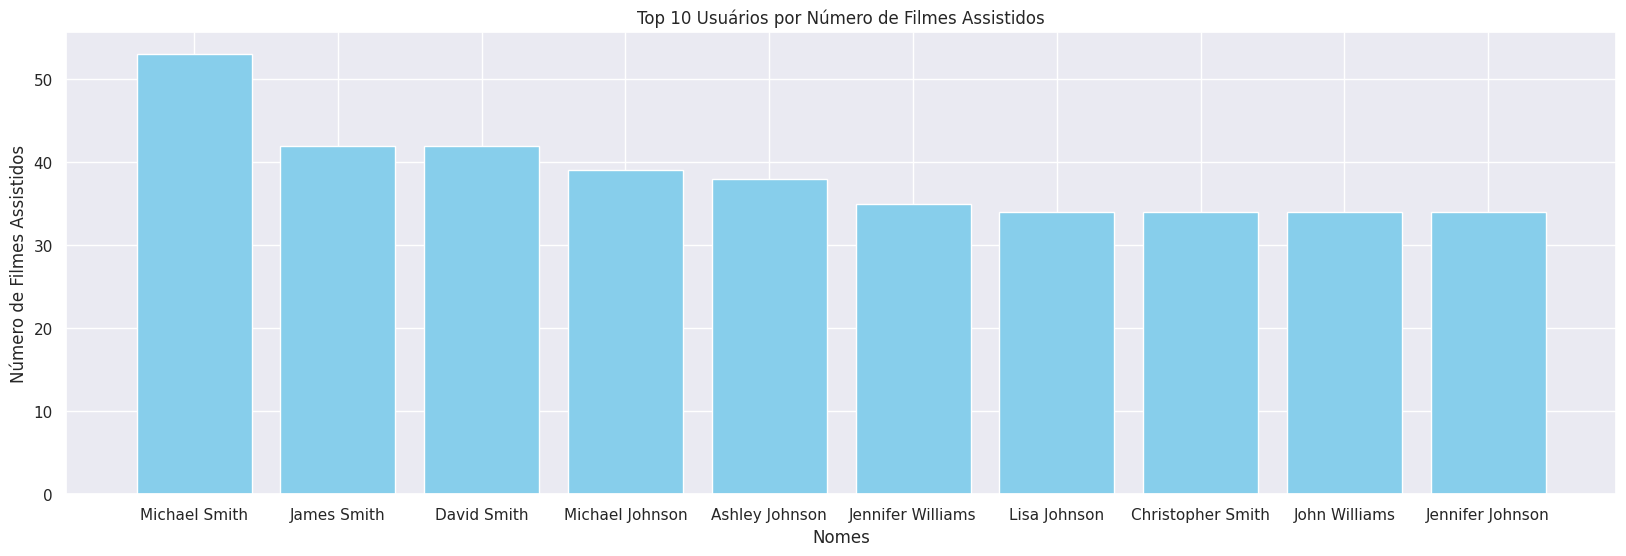

In [ ]:
# Supondo que 'dbDataset' seja seu DataFrame
dfPH = dbDataset

# Agrupar por 'full_name' e contar o número de filmes assistidos por usuário
contagem_filmes_por_usuario = dfPH.groupby('full_name')['title'].count().reset_index()

# Ordenar em ordem decrescente e pegar os top 10
top_10_usuarios = contagem_filmes_por_usuario.sort_values(by='title', ascending=False).head(10)

# Criar um gráfico de barras para o top 10
plt.figure(figsize=(20, 6))
plt.bar(top_10_usuarios['full_name'], top_10_usuarios['title'], color='skyblue')

# Adicionar rótulos e título
plt.xlabel('Nomes')
plt.ylabel('Número de Filmes Assistidos')
plt.title('Top 10 Usuários por Número de Filmes Assistidos')

plt.show()


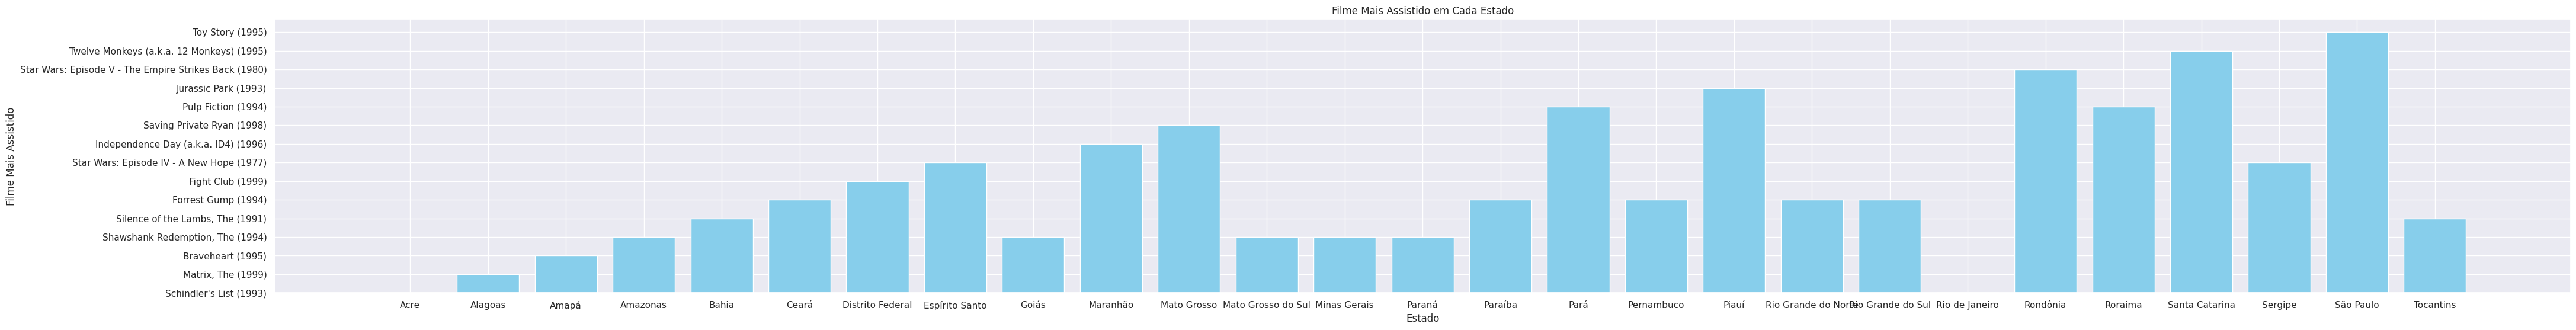

In [ ]:
dfPH = pd.DataFrame(dbDataset)

# Encontrar o filme mais assistido em cada estado
filmes_mais_assistidos_por_estado = dfPH.groupby('states')['title'].apply(lambda x: x.value_counts().idxmax())

# Criar um gráfico de barras para o filme mais assistido em cada estado
plt.figure(figsize=(50, 6))
plt.bar(filmes_mais_assistidos_por_estado.index, filmes_mais_assistidos_por_estado.values, color='skyblue')

# Adicionar rótulos e título
plt.xlabel('Estado')
plt.ylabel('Filme Mais Assistido')
plt.title('Filme Mais Assistido em Cada Estado')

plt.show()

In [ ]:
dfPH = pd.DataFrame(dbDataset)

# Converter o timestamp para datetime
dfPH['timestamp'] = pd.to_datetime(dfPH['timestamp'])

# Criar um histograma com contagem de classificações
figure = px.histogram(dfPH, x="timestamp", y="rating",
                      title="Tendência de Contagem de Classificações ao Longo do Tempo")

figure.show()

In [ ]:
# Agregar por filme
ag_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
number_of_ratings = ('rating', 'count')).reset_index()

# Manter movies com rating acima de 100
agg_ratings_GT100 = ag_ratings[ag_ratings['number_of_ratings']>100]

# Verificando informação do dataframe
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 60 to 10204
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              150 non-null    object 
 1   mean_rating        150 non-null    float64
 2   number_of_ratings  150 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ KB


In [ ]:
#Verificando o filme mais popular
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

title  mean_rating  number_of_ratings
7323               Pulp Fiction (1994)     4.160000                325
3349               Forrest Gump (1994)     4.138264                311
8136  Shawshank Redemption, The (1994)     4.454545                308
4934              Jurassic Park (1993)     3.659864                294
8228  Silence of the Lambs, The (1991)     4.194828                290

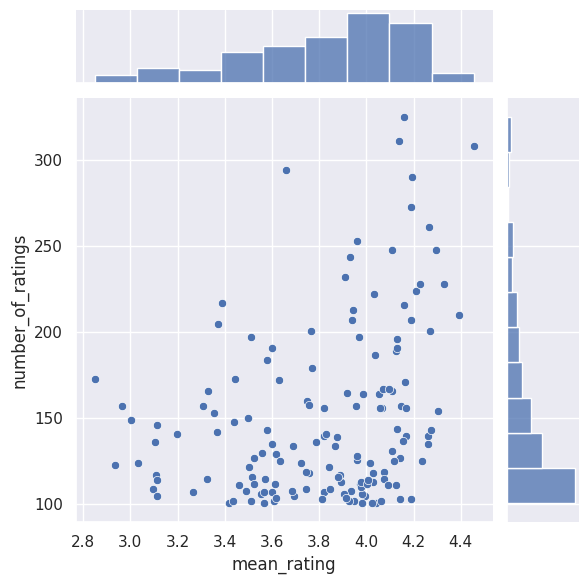

In [ ]:
# Gráfico de Visualização
# Número de Rating pela média de Rating
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [ ]:
# Mesclar dados
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22556 entries, 0 to 22555
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    22556 non-null  int64  
 1   title      22556 non-null  object 
 2   genres     22556 non-null  object 
 3   userId     22556 non-null  int64  
 4   rating     22556 non-null  float64
 5   timestamp  22556 non-null  int64  
 6   age        22556 non-null  int64  
 7   salary     22556 non-null  float64
 8   full_name  22556 non-null  object 
 9   states     22556 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 1.9+ MB


In [ ]:
# Número de usuários
print('O dataset de ratings tem', df_GT100['userId'].nunique(), 'usuários')

# Número de filmes
print('O dataset de ratings tem', df_GT100['movieId'].nunique(), 'Filmes')

# Número de avaliações
print('O dataset de ratings tem', df_GT100['rating'].nunique(), 'Avaliações')

# Lista de classificações exclusivas
print('O dataset de ratings tem', sorted(df_GT100['rating'].unique()))

O dataset de ratings tem 653 usuários
O dataset de ratings tem 150 Filmes
O dataset de ratings tem 10 Avaliações
O dataset de ratings tem [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [ ]:
#Criação de Matriz Usuário-Filme
matriz = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matriz.head()

userId                             1    2    3    4    5    6    7    8    \
title                                                                       
2001: A Space Odyssey (1968)       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Ace Ventura: Pet Detective (1994)  NaN  NaN  NaN  NaN  1.0  NaN  1.0  NaN   
Aladdin (1992)                     NaN  NaN  3.0  NaN  3.5  NaN  NaN  NaN   
Alien (1979)                       NaN  NaN  NaN  NaN  NaN  NaN  5.0  NaN   
Aliens (1986)                      NaN  NaN  NaN  NaN  NaN  NaN  5.0  NaN   

userId                             9    10   ...  659  660  661  662  663  \
title                                        ...                            
2001: A Space Odyssey (1968)       NaN  NaN  ...  NaN  NaN  NaN  5.0  NaN   
Ace Ventura: Pet Detective (1994)  2.0  NaN  ...  NaN  NaN  NaN  NaN  NaN   
Aladdin (1992)                     NaN  NaN  ...  3.0  NaN  NaN  NaN  NaN   
Alien (1979)                       NaN  NaN  ...  NaN  NaN  NaN  5.0  NaN   
Aliens (1986)                      NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   

userId                             664  665  666  667  668  
title                                                       
2001: A Space Odyssey (1968)       NaN  NaN  NaN  NaN  3.0  
Ace Ventura: Pet Detective (1994)  NaN  3.0  NaN  3.5  NaN  
Aladdin (1992)                     NaN  NaN  NaN  NaN  3.0  
Alien (1979)                       2.0  NaN  4.0  NaN  4.0  
Aliens (1986)                      NaN  NaN  NaN  NaN  3.5  

[5 rows x 653 columns]

In [ ]:
#Normalização dos dados
matriz_norm = matriz.subtract(matriz.mean(axis=1), axis = 0)
matriz_norm.head()

userId                             1    2         3    4         5    6    \
title                                                                       
2001: A Space Odyssey (1968)       NaN  NaN       NaN  NaN       NaN  NaN   
Ace Ventura: Pet Detective (1994)  NaN  NaN       NaN  NaN -1.849711  NaN   
Aladdin (1992)                     NaN  NaN -0.602094  NaN -0.102094  NaN   
Alien (1979)                       NaN  NaN       NaN  NaN       NaN  NaN   
Aliens (1986)                      NaN  NaN       NaN  NaN       NaN  NaN   

userId                                  7    8         9    10   ...  \
title                                                            ...   
2001: A Space Odyssey (1968)            NaN  NaN       NaN  NaN  ...   
Ace Ventura: Pet Detective (1994) -1.849711  NaN -0.849711  NaN  ...   
Aladdin (1992)                          NaN  NaN       NaN  NaN  ...   
Alien (1979)                       0.935897  NaN       NaN  NaN  ...   
Aliens (1986)                      0.853503  NaN       NaN  NaN  ...   

userId                                  659  660  661       662  663  \
title                                                                  
2001: A Space Odyssey (1968)            NaN  NaN  NaN  1.039683  NaN   
Ace Ventura: Pet Detective (1994)       NaN  NaN  NaN       NaN  NaN   
Aladdin (1992)                    -0.602094  NaN  NaN       NaN  NaN   
Alien (1979)                            NaN  NaN  NaN  0.935897  NaN   
Aliens (1986)                           NaN  NaN  NaN       NaN  NaN   

userId                                  664       665       666       667  \
title                                                                       
2001: A Space Odyssey (1968)            NaN       NaN       NaN       NaN   
Ace Ventura: Pet Detective (1994)       NaN  0.150289       NaN  0.650289   
Aladdin (1992)                          NaN       NaN       NaN       NaN   
Alien (1979)                      -2.064103       NaN -0.064103       NaN   
Aliens (1986)                           NaN       NaN       NaN       NaN   

userId                                  668  
title                                        
2001: A Space Odyssey (1968)      -0.960317  
Ace Ventura: Pet Detective (1994)       NaN  
Aladdin (1992)                    -0.602094  
Alien (1979)                      -0.064103  
Aliens (1986)                     -0.646497  

[5 rows x 653 columns]

In [ ]:
#Cálculo da Pontuação de Similaridade
item_similarity = matriz_norm.T.corr()
item_similarity.head()

title                              2001: A Space Odyssey (1968)  \
title                                                             
2001: A Space Odyssey (1968)                           1.000000   
Ace Ventura: Pet Detective (1994)                      0.009197   
Aladdin (1992)                                         0.094955   
Alien (1979)                                           0.161791   
Aliens (1986)                                          0.111129   

title                              Ace Ventura: Pet Detective (1994)  \
title                                                                  
2001: A Space Odyssey (1968)                                0.009197   
Ace Ventura: Pet Detective (1994)                           1.000000   
Aladdin (1992)                                              0.045501   
Alien (1979)                                                0.220471   
Aliens (1986)                                               0.017538   

title                              Aladdin (1992)  Alien (1979)  \
title                                                             
2001: A Space Odyssey (1968)             0.094955      0.161791   
Ace Ventura: Pet Detective (1994)        0.045501      0.220471   
Aladdin (1992)                           1.000000      0.131826   
Alien (1979)                             0.131826      1.000000   
Aliens (1986)                            0.256574      0.556528   

title                              Aliens (1986)  \
title                                              
2001: A Space Odyssey (1968)            0.111129   
Ace Ventura: Pet Detective (1994)       0.017538   
Aladdin (1992)                          0.256574   
Alien (1979)                            0.556528   
Aliens (1986)                           1.000000   

title                              Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)  \
title                                                                                     
2001: A Space Odyssey (1968)                                                0.255150      
Ace Ventura: Pet Detective (1994)                                           0.184113      
Aladdin (1992)                                                              0.188945      
Alien (1979)                                                                0.008468      
Aliens (1986)                                                               0.179657      

title                              American Beauty (1999)  \
title                                                       
2001: A Space Odyssey (1968)                     0.326736   
Ace Ventura: Pet Detective (1994)                0.264089   
Aladdin (1992)                                   0.074428   
Alien (1979)                                     0.272213   
Aliens (1986)                                    0.195056   

title                              American History X (1998)  \
title                                                          
2001: A Space Odyssey (1968)                       -0.116787   
Ace Ventura: Pet Detective (1994)                   0.092017   
Aladdin (1992)                                      0.293284   
Alien (1979)                                        0.115971   
Aliens (1986)                                       0.200158   

title                              American Pie (1999)  Apocalypse Now (1979)  \
title                                                                           
2001: A Space Odyssey (1968)                  0.339217               0.375652   
Ace Ventura: Pet Detective (1994)             0.536903              -0.231039   
Aladdin (1992)                                0.363807               0.027862   
Alien (1979)                                  0.326924               0.189564   
Aliens (1986)                                 0.339430               0.305410   

title                              ...  Truman Show, The (1998)  \
title                              ...  

In [ ]:
# Matriz de similaridade de itens usando similaridade de cosseno
item_similarity_cosine = cosine_similarity(matriz_norm.fillna(0))
item_similarity_cosine

array([[ 1.        ,  0.00239804,  0.03036161, ...,  0.03045315,
         0.1869451 ,  0.02662157],
       [ 0.00239804,  1.        ,  0.02847017, ...,  0.10816846,
        -0.01071678,  0.03320306],
       [ 0.03036161,  0.02847017,  1.        , ...,  0.13555956,
         0.08855735,  0.09631236],
       ...,
       [ 0.03045315,  0.10816846,  0.13555956, ...,  1.        ,
         0.10176866,  0.04128851],
       [ 0.1869451 , -0.01071678,  0.08855735, ...,  0.10176866,
         1.        ,  0.00957729],
       [ 0.02662157,  0.03320306,  0.09631236, ...,  0.04128851,
         0.00957729,  1.        ]])

In [ ]:
# Predição da Avaliação do Usuário para um Filme
# Pegar um usuário
usuario_escolhido = 7

# Pegar um Filme
filme_escolhido = 'Star Wars: Episode IV - A New Hope (1977)'

# Filmes que o usuário escolhido assitiu
picked_userid_watched = pd.DataFrame(matriz_norm[usuario_escolhido].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={7:'rating'})

picked_userid_watched.head()

title    rating
0       Austin Powers: The Spy Who Shagged Me (1999)  1.893162
1                  Die Hard: With a Vengeance (1995)  1.500000
2                Monty Python's Life of Brian (1979)  1.189320
3  Austin Powers: International Man of Mystery (1...  1.084158
4                                    Die Hard (1988)  1.081818

In [ ]:
# Pontuação de similaridade do filme Star Wars: Episode IV - A New Hope (1977) com todos os outros filmes
picked_movie_similarity_score = item_similarity[[filme_escolhido]].reset_index().rename(columns={'Star Wars: Episode IV - A New Hope (1977)':'similarity_score'})

# Classifica as semelhanças entre os filmes avaliados pelo usuário 7 e Star Wars: Episódio IV.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                            right=picked_movie_similarity_score,
                                            on='title',
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]

# Dê uma olhada nos filmes assistidos pelo usuário 1 com maior similaridade
picked_userid_watched_similarity

title    rating  \
20          Star Wars: Episode IV - A New Hope (1977)  0.811355   
23  Star Wars: Episode V - The Empire Strikes Back...  0.771930   
10  Star Wars: Episode VI - Return of the Jedi (1983)  0.968468   
3   Austin Powers: International Man of Mystery (1...  1.084158   
58  Pirates of the Caribbean: The Curse of the Bla... -1.329787   

    similarity_score  
20          1.000000  
23          0.725627  
10          0.657868  
3           0.541216  
58          0.428312

In [ ]:
# Calcular a classificação prevista usando a média ponderada das pontuações de similaridade e as avaliações do usuário 1
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

print(f'The predicted rating for {filme_escolhido} by user {usuario_escolhido} is {predicted_rating}' )

The predicted rating for Star Wars: Episode IV - A New Hope (1977) by user 7 is 0.604175


In [ ]:
def train_and_evaluate_model_for_user(df, user_id):

    # Filtrar dados para o usuário específico
    user_data = df[df['userId'] == user_id]

    # Crie um leitor Suprise
    reader = Reader(rating_scale=(0, 5))

    # Carregar dados do Pandas DataFrame
    data = Dataset.load_from_df(user_data[['userId', 'movieId', 'rating']], reader)

    # Divida os dados em conjuntos de treinamento e teste
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

    #Algoritmo (SVD neste caso por ser matriz)
    model = SVD()

    # Treine o modelo
    model.fit(trainset)

    # Faça previsões no conjunto de testes
    predictions = model.test(testset)

    # Avalie o desempenho do modelo
    rmse = accuracy.rmse(predictions)
    print(f'RMSE on test set for user {user_id}: {rmse:.4f}')

    # Exemplo de previsão para um filme específico
    movie_id = '5'
    predicted_rating = model.predict(user_id, movie_id)
    print(f'Predicted rating for movie {movie_id} by user {user_id}: {predicted_rating.est:.2f}')

unique_user_ids = dbDataset['userId'].unique()


In [ ]:
train_and_evaluate_model_for_user(dbDataset, 7)

RMSE: 1.0987
RMSE on test set for user 7: 1.0987
Predicted rating for movie 5 by user 7: 3.61


In [ ]:

def item_based_rec(picked_userid, number_of_similar_items, number_of_recommendations):
    # Filmes que o usuário alvo não assistiu
    import operator
    picked_userid_unwatched = pd.DataFrame(matriz_norm[picked_userid].isna()).reset_index()
    picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[picked_userid] == True]['title'].values.tolist()

    # Filmes que o usuário alvo assistiu
    picked_userid_watched = pd.DataFrame(matriz_norm[picked_userid].dropna(axis=0, how='all') \
                                         .sort_values(ascending=False)) \
        .reset_index() \
        .rename(columns={picked_userid: 'rating'})
    # Dicionário para salvar o filme não assistido e o par de classificação prevista
    rating_prediction = {}

    # Percorra filmes não assistidos
    for picked_movie in picked_userid_unwatched:
        # Calcule a pontuação de similaridade do filme escolhido com outros filmes
        picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(
            columns={picked_movie: 'similarity_score'})

        # Classifique as semelhanças entre o filme assistido pelo usuário escolhido e o filme não assistido escolhido.
        picked_userid_watched_similarity = pd.merge(left=picked_userid_watched,
                                                    right=picked_movie_similarity_score,
                                                    on='title',
                                                    how='inner') \
            .sort_values('similarity_score', ascending=False)[:number_of_similar_items]

        # Calcule a classificação prevista usando a média ponderada das pontuações de similaridade e as avaliações do usuário escolhido
        predicted_rating = round(np.average(picked_userid_watched_similarity['rating'],
                                            weights=picked_userid_watched_similarity['similarity_score']), 6)

        # Salve a classificação prevista no dicionário
        rating_prediction[picked_movie] = predicted_rating

    return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]


# Exemplo de uso para recomendação baseada em histórico
recommended_movie_history = item_based_rec(picked_userid=10, number_of_similar_items=5,
                                           number_of_recommendations=3)

print("History-based recommendation:", recommended_movie_history)


History-based recommendation: [('Incredibles, The (2004)', 3.935052), ('Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 1.435516), ('Apocalypse Now (1979)', 0.649829)]
